# Training CNN to Estimate Affordance Variables on GTA V Screenshot data

### General Information

Please visit main website: https://princetonautonomous.github.io/, if you haven't. It contains useful information as well as a link to the paper.

- Format of the input images

- Format of the annotation file

### Import Required Packages

In [1]:
%matplotlib inline

import random
import threading
import time
from os import listdir

import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from scipy import misc
import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Set Parameters

In [2]:
# Set path to directory containing images
TRAIN_IMAGES = '/D/GTA_data/train/data/'
# Set path to the annotation file
TRAIN_ANNOT = '/D/GTA_data/train/annotation_scale.txt'

TEST_IMAGES = '/D/GTA_data/test/data/'
TEST_ANNOT = '/D/GTA_data/test/annotation_scale.txt'

VALID_IMAGES = '/D/GTA_data/valid/data/'
VALID_ANNOT = '/D/GTA_data/valid/annotation_scale.txt'

# Set path to the mean of training set 
# (Ignore this when running for the first time)
MEAN_IMAGE = '/D/GTA_data/train/mean.bmp'
# Set Number of affordance variables
NUM_LABELS = 8

batch_size = 32                # Set size of the batch
input_shape = (210, 280, 3)    # Set input shape of CNN
output_dim = NUM_LABELS        # Number of output dimension     
num_epoch = 100                # Number of epoch to train

# Determine number of batches in the dataset
train_files = [f for f in listdir(TRAIN_IMAGES)]
num_steps = len(train_files) / batch_size

test_files = [f for f in listdir(TEST_IMAGES)]
test_num_steps = len(test_files) / batch_size

valid_files = [f for f in listdir(VALID_IMAGES)]
val_num_steps = len(valid_files) / batch_size

### Build the Model

We use a modified version of AlexNet. There is an extra fully-connected layer at the end of the network with `output_dim` neurons and tanh as activation function.

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

# AlexNet with batch normalization in Keras 

model = Sequential()
model.add(Convolution2D(64, (11, 11), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Convolution2D(128, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Convolution2D(192, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Convolution2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(4096, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4096, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1000, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Dense(output_dim, kernel_initializer='normal', activation='tanh'))

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='mse')

In [4]:
# Print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 210, 280, 64)      23296     
_________________________________________________________________
batch_normalization_1 (Batch (None, 210, 280, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 210, 280, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 70, 93, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 93, 128)       401536    
_________________________________________________________________
batch_normalization_2 (Batch (None, 70, 93, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 70, 93, 128)       0         
__________

### Setup a Generator

A generator is needed to feed in samples to the network since dataset is too large to fit in the RAM. The code below is adapted from https://github.com/fchollet/keras/issues/1638.

In [5]:
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g


@threadsafe_generator
def myGenerator(img_dir, ant_path, batch_size):  # write the definition of your data generator
    
    # List all files in directory
    filenames = [f for f in listdir(img_dir)]
    filenames.sort()
    # Read annotation into a list
    with open(ant_path) as ant:
        annotation = ant.readlines()
        annotation = [x.strip() for x in annotation] 
    
    # Shuffle image filenames
    random.seed(1234)
    random.shuffle(filenames)
    random.seed(1234)
    random.shuffle(annotation)
    
    # Load mean image for mean subtraction
    mean = cv2.imread(MEAN_IMAGE)
    mean = cv2.cvtColor(mean, cv2.COLOR_BGR2RGB)
    
    while 1:
        for batch in range(len(filenames) / batch_size):
            x_batch = np.zeros((batch_size, 210, 280, 3), dtype=np.float32)
            y_batch = np.zeros((batch_size, output_dim), dtype=np.float32)
            j = batch * batch_size
            
            for i in range(batch_size):
                im = cv2.imread(img_dir + filenames[j + i])
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                x_batch[i] = im - mean
                y_batch[i] = annotation[j + i].split(',')[2:]
                
            x_batch /= 255.
            yield x_batch, y_batch

In [6]:
# Load weights
#model.load_weights('./best_weights.hdf5')
model.load_weights('./temp.hdf5')

In [5]:
best_weights_filepath = 'weights.{epoch:02d}-{val_loss:.5f}.hdf5'
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
saveBestModel = keras.callbacks.ModelCheckpoint(best_weights_filepath, monitor='val_loss', 
                                                verbose=1, save_best_only=True, mode='auto')

In [6]:
model.load_weights('./epoch10.hdf5')

In [62]:
model.evaluate_generator(myGenerator(VALID_IMAGES, VALID_ANNOT, batch_size), 
                         val_num_steps, max_queue_size=100, workers=4)

0.31409590826379308

In [8]:
model.load_weights('./epoch21.hdf5')
model.evaluate_generator(myGenerator(VALID_IMAGES, VALID_ANNOT, batch_size), 
                         val_num_steps, max_queue_size=100, workers=4)

0.31650570219095597

In [ ]:
model.load_weights('./epoch5.hdf5')
model.evaluate_generator(myGenerator(VALID_IMAGES, VALID_ANNOT, batch_size), 
                         val_num_steps, max_queue_size=100, workers=4)

In [ ]:
for i in range(2,2,20):
    if i == 10:
        continue
    model.load_weights('./epoch' + str(i) + '.hdf5')
    model.evaluate_generator(myGenerator(VALID_IMAGES, VALID_ANNOT, batch_size), 
                         val_num_steps, max_queue_size=100, workers=4)

In [6]:
batch_per_chunk = 200
chunk_size = batch_per_chunk * batch_size
num_chunk = len(train_files) / chunk_size
val_num_chunk = len(valid_files) / chunk_size

In [7]:
def load_data(img_dir, ant_path):
    
    # List all files in directory
    filenames = [f for f in listdir(img_dir)]
    filenames.sort()
    # Read annotation into a list
    with open(ant_path) as ant:
        annotation = ant.readlines()
        annotation = [x.strip() for x in annotation] 

    # Shuffle image filenames
    random.seed(1234)
    random.shuffle(filenames)
    random.seed(1234)
    random.shuffle(annotation)    

    return filenames, annotation

In [8]:
# Load mean image for mean subtraction
mean = cv2.imread(MEAN_IMAGE)
mean = cv2.cvtColor(mean, cv2.COLOR_BGR2RGB)

filenames, annotation = load_data(TRAIN_IMAGES, TRAIN_ANNOT)
val_filenames, val_annotation = load_data(VALID_IMAGES, VALID_ANNOT)

for epoch in range(num_epoch):
    
    # Start training
    print 'Starting epoch ' + str(epoch)
    start_epoch = time.time()
    for chunk in range(num_chunk):
        
        start_time = time.time()
        j = chunk * chunk_size
        # Load training "chunk" of data onto memory 
        x_chunk = np.array([cv2.cvtColor(cv2.imread(TRAIN_IMAGES + fn), cv2.COLOR_BGR2RGB) 
                            for fn in filenames[j : j + chunk_size]], dtype=np.float32)
        x_chunk -= mean
        x_chunk /= 255.
        y_chunk = np.array([ant.split(',')[2:] for ant in annotation[j : j + chunk_size]])
        
        # Fit with the current chunk
        model.fit(x_chunk, y_chunk, batch_size=batch_size, epochs=1, 
                  verbose=1, shuffle=False, initial_epoch=epoch)
        
        print 'Chunk ' + str(chunk) + ' finished in ' + str(time.time() - start_time)
    
    print 'Epoch ' + str(epoch) + ' finished in ' + str(time.time() - start_epoch)
    
    # Start evaluation
    start_val = time.time()
    val_loss = 0
    for chunk in range(val_num_chunk):
        
        j = chunk * chunk_size
        # Load validate "chunk" of data onto memory 
        x_chunk = np.array([cv2.cvtColor(cv2.imread(TRAIN_IMAGES + fn), cv2.COLOR_BGR2RGB) 
                            for fn in val_filenames[j : j + chunk_size]], dtype=np.float32)
        x_chunk -= mean
        x_chunk /= 255.
        y_chunk = np.array([ant.split(',')[2:] for ant in val_annotation[j : j + chunk_size]])
        
        # Evaluate the current chunk
        val_loss += evaluate(x_chunk, y_chunk, batch_size=batch_size, verbose=1)
    
    print 'Total val_loss: ' + str(val_loss) + ', finished in ' + str(time.time() - start_val)

    model.save_weights('epoch{}_val_loss{}.hdf5'.format(epoch, val_loss))

Starting epoch 0
Epoch 1/1
6400/6400 [==============================] - 128s - loss: 1.1499   
Chunk 0 finished in 190.875389099
Epoch 1/1
6400/6400 [==============================] - 123s - loss: 0.7219   
Chunk 1 finished in 219.211694002
Epoch 1/1
6400/6400 [==============================] - 123s - loss: 0.4854   
Chunk 2 finished in 236.101496935
Epoch 1/1
4384/6400 [===================>..........] - ETA: 38s - loss: 0.4375

KeyboardInterrupt: 

In [8]:
model.evaluate_generator(myGenerator(VALID_IMAGES, VALID_ANNOT, batch_size), 
                         val_num_steps, max_queue_size=1000, workers=4)

0.33492468957057714

In [ ]:
model.fit_generator(myGenerator(TRAIN_IMAGES, TRAIN_ANNOT, batch_size), 
                    num_steps, epochs=num_epoch, verbose=1, 
                    validation_data=myGenerator(VALID_IMAGES, VALID_ANNOT, batch_size), 
                    validation_steps=val_num_steps, max_queue_size=1000, 
                    workers=4, use_multiprocessing=False, initial_epoch=1,
                    callbacks=[earlyStopping, saveBestModel])

In [27]:
# Max values to scale [-0.9, 0.9]
angle_max = float(angle_lim) * 10 / 9
car_dist_max = float(car_dist_lim) * 10 / 9
car_dist_inac = car_dist_max * 1.25
lane_dist_lim = 11
lane_dist_max = lane_dist_lim * 10 / 9
lane_dist_inac = lane_dist_max * 1.25

In [12]:
model.save_weights('temp.hdf5')

In [88]:
with open('/D/GTA_data/valid/annotation_scale.txt') as ant:
    annotation = ant.readlines()
    annotation = [x.strip() for x in annotation] 

annot = np.zeros((len(annotation), NUM_LABELS))
for i in range(len(annotation)):
    annot[i] = annotation[i].split(',')[2:] 

In [89]:
def predict(model, filepath):
    
    mean = cv2.imread(MEAN_IMAGE)
    mean = cv2.cvtColor(mean, cv2.COLOR_BGR2RGB)
    
    im = cv2.imread(filepath)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = (im - mean) / 255.
    im = im.reshape((1, 210, 280, 3))
    
    return model.predict(im, batch_size=1, verbose=0)[0]

In [90]:
filenames = [f for f in listdir(VALID_IMAGES)]
filenames.sort()

35880
41369
40115
[ -5.21258956e-02   6.33243052e+01   4.25997017e+01   6.33324631e+01
   7.72984177e+00   2.08514988e+00   3.00283641e+00   1.14992894e+01]
[ -7.56225600e-02   8.33333333e+01   1.99812500e+01   8.33333333e+01
   8.79694300e+00   3.39694300e+00   2.00305700e+00   1.50000000e+01]


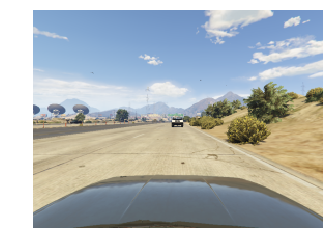

16948
25993
43649
[  0.58188569  63.33333333  20.86209734  63.33333333  11.49995816
   3.30836111   1.85773396  11.49999213]
[ -0.8280182   83.33333333  42.61874     83.33333333  15.           3.138294
   2.261706    15.        ]


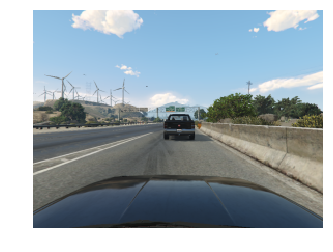

44915
36092
894
28835
24030
[  0.16541278  63.33068689  63.25147033  63.33315452   7.77692187
   1.90257835   3.39200956  11.49858022]
[ -4.09221600e-02   8.33333333e+01   8.33333333e+01   8.33333333e+01
   7.17532400e+00   1.77532400e+00   3.62467600e+00   1.50000000e+01]


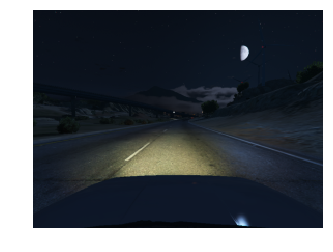

25702
30390
[  1.47000415  61.58476551  63.33333333  63.33324194   8.58571768
   2.74682295   3.20695198  11.48568809]
[  0.3364563   83.33333333  83.33333333  83.33333333   6.461839     1.061839
   4.338161    15.        ]


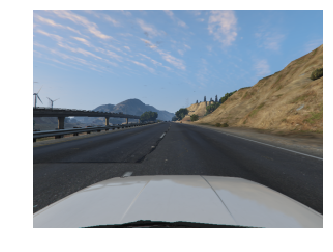

15167
31025
[ -0.15140513   7.63149738  19.65949814  63.33303332   8.57806659
   2.9213568    2.42405486  11.49915349]
[ -0.2329102   11.08047     19.84434     83.33333333   8.850736     3.450736
   1.949264    15.        ]


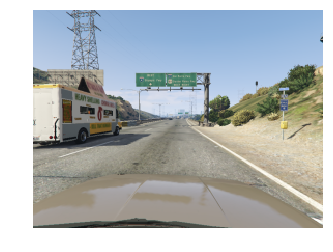

25154
[ -2.56007363  63.33333333  20.78670045  63.33333333  11.49999785
   2.78789133   2.39911282  11.49988699]
[ -0.4015198   83.33333333  14.07547     83.33333333  15.           2.797497
   2.602503    15.        ]


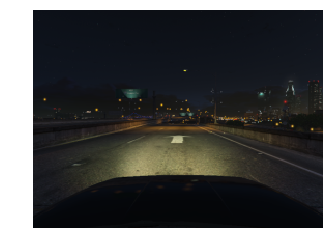

11367
6956
[  0.0679397   19.59830602  18.15104067  63.09379419   7.97693795
   2.42599177   2.97478765  11.44646132]
[ -0.5686646   38.97601     14.10121     83.33333333   7.544209     2.14421
   3.25579     15.        ]


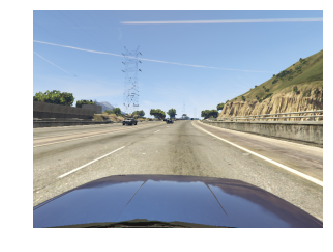

3356
[  0.21880682  59.43293452  39.34697191  63.33332141   8.24288863
   2.60748219   2.73407245  11.5       ]
[  1.131226    53.53001     25.88498     83.33333333   7.909617     2.509617
   2.890383    15.        ]


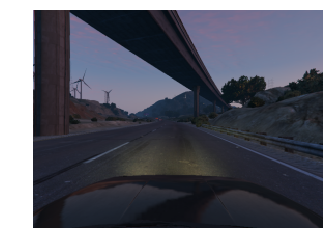

19921
[  0.39024192  22.15041349  12.09958474  63.33333135   8.51540017
   2.66846812   2.62012792  11.49998784]
[  2.70385700e-02   1.86407300e+01   1.84164700e+01   8.33333333e+01
   8.16798000e+00   2.76798000e+00   2.63202000e+00   1.50000000e+01]


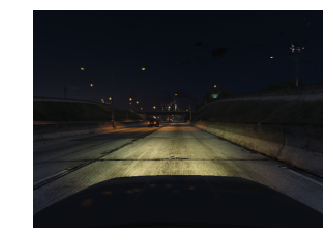

25446
[  5.90690722e-02   6.30742260e+01   6.84253454e+00   6.33327810e+01
   1.14518805e+01   2.26466119e+00   3.00747627e+00   1.14970553e+01]
[  0.128418    83.33333333   8.22208     83.33333333  15.           3.080029
   2.319971    15.        ]


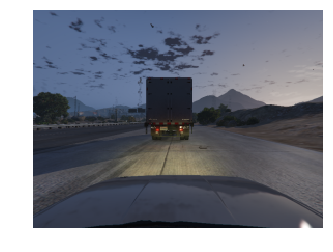

36653
[  0.06701372  63.33333333  63.33063523  63.21339885  11.49670267
   1.92060924   3.32888824  11.47472215]
[  0.8886719   83.33333333  83.33333333  83.33333333  15.           2.082908
   3.317092    15.        ]


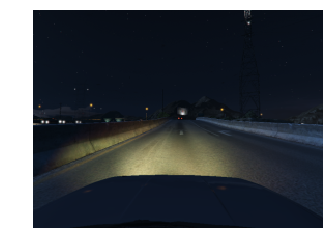

42840
15996
7619
27298
[  0.95631486  63.33330154  46.16190672  63.30258131   9.95735288
   2.00753713   3.21306884  11.38463569]
[ -1.213928    83.33333333  83.33333333  83.33333333   7.758481     2.358481
   3.041519    15.        ]


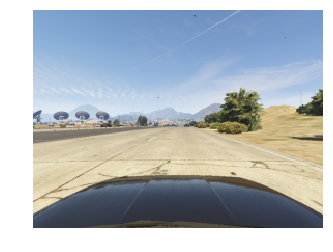

31629
22433
29974
44989
[ -1.0183479   63.33328366   8.31981182  63.33332936  11.49936664
   2.4037348    2.86230975  11.49998713]
[ -7.920845    83.33333333   1.348866    83.33333333  15.           4.346248
   1.053752     9.746248  ]


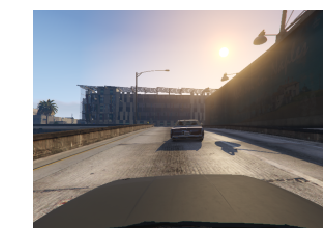

39923
[  0.2442662   51.84776068  63.32431515  63.33331148   8.87298691
   2.8618983    2.46762609  11.49999285]
[ -0.1444569   83.33333333  83.33333333  83.33333333   8.508057     3.108057
   2.291944    15.        ]


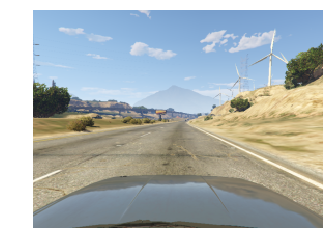

28267
[ -0.47153312  14.26933487  19.62387045  63.33330552   8.69728327
   3.04648936   2.27304935  11.4999696 ]
[  0.1101532   31.65811     13.22779     83.33333333   8.047564     2.647563
   2.752437    15.        ]


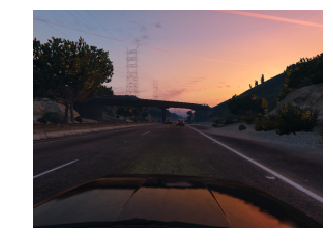

8687
[  0.3318253   63.33268364  26.49632399  63.33320022  11.48988414
   2.16842604   3.04214114  11.49751306]
[  4.620255    83.33333333   9.914325    83.33333333  15.           1.499409
   3.900592    15.        ]


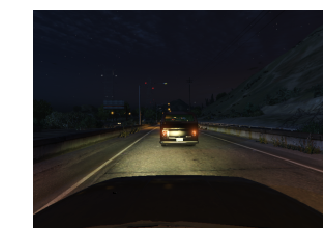

27263
[ -0.18506227  63.33328366  63.33333333  63.33260616   7.20542681
   1.23685265   3.86042875  11.49936271]
[ -0.926239    83.33333333  83.33333333  83.33333333   7.551069     2.151069
   3.248931    15.        ]


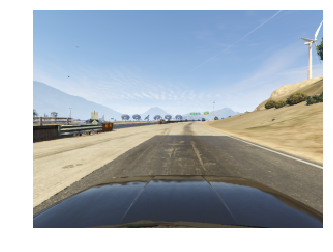

38106
[ -0.97130475  63.33333135   5.4723231   63.33332737  11.49991488
   2.86009586   2.44141269  11.49975252]
[ -2.616493    83.33333333   6.959452    83.33333333  15.           2.327178
   3.072822    15.        ]


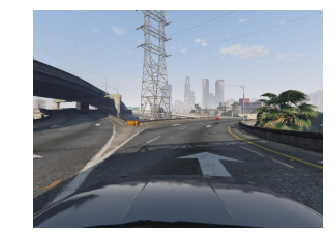

21438
9031
[ -0.15016352  -1.032902    11.81693951  63.33333333   8.83168912
   3.2620821    2.10292006  11.49999821]
[  0.4589386    1.178106    10.68956     83.33333333   7.771773     2.371773
   3.028228    15.        ]


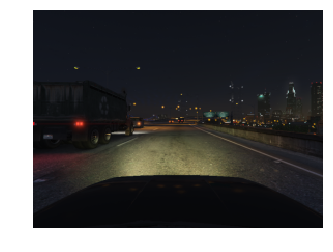

33739
15965
[ -0.08593698  32.84098089  63.32977891  63.33319028   8.74922299
   2.72713429   2.48526001  11.49992955]
[ -0.1369476   23.28921     83.33333333  83.33333333   8.034411     2.634411
   2.765589    15.        ]


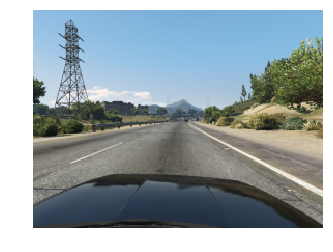

14931
2692
[ -5.13381247e-02   5.91309714e+01   6.33333135e+01   6.33333333e+01
   9.06424880e+00   3.11411822e+00   2.08205104e+00   1.15000000e+01]
[ -1.08623500e-02   8.33333333e+01   8.33333333e+01   8.33333333e+01
   8.96668300e+00   3.56668400e+00   1.83331700e+00   1.50000000e+01]


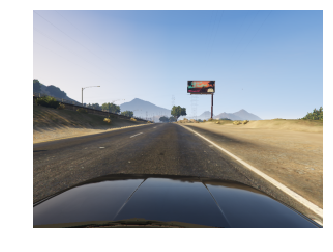

31497
[  0.63375973  63.33333333   4.76599216  63.33333333  11.49997747
   3.46149307   1.95627046  11.49993777]
[  6.46133400e-02   8.33333333e+01   1.90000800e+01   8.33333333e+01
   1.50000000e+01   3.13386500e+00   2.26613500e+00   1.50000000e+01]


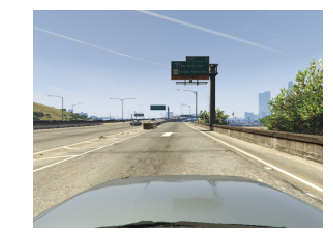

32610
[ -0.22864362   3.43740265  63.33333333  63.3333234    8.98513865
   2.40668058   2.60568333  11.49997103]
[ -0.950882    23.50038     83.33333333  83.33333333   7.795016     2.395016
   3.004984    15.        ]


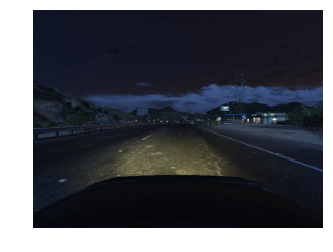

23086
[ -0.20903453  63.08305939  52.21684059  63.33273133  11.49501681
   2.73363847   2.46048927  11.46925437]
[ -0.434967    83.33333333  83.33333333  83.33333333  15.           3.451132
   1.948868    15.        ]


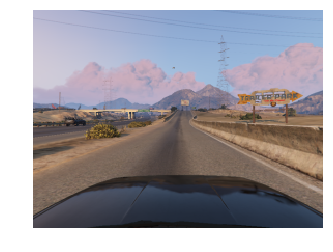

30704
[ -0.3596033   19.06036715  21.54540996  63.33328366   8.28501916
   2.4952178    2.80440891  11.49991739]
[ -1.324005    15.64527      9.251391    83.33333333   7.675819     2.275819
   3.124181    15.        ]


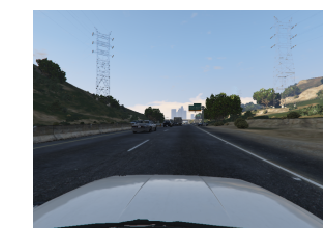

11330
[-11.98486984  63.33331943  10.06457885  63.33333333  11.49156177
   2.36506271   2.99936098  11.49999857]
[-25.46423     83.33333333  19.11453     83.33333333  15.           1.752546
   3.647454    15.        ]


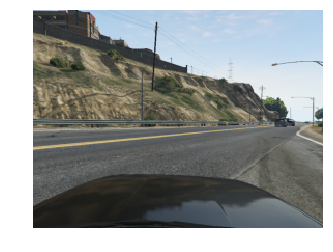

31049
[ -0.38969386  63.33323797   5.49776236  63.33332936  11.49899435
   3.10616815   2.16853011  11.49975288]
[ -0.313446    83.33333333   8.038489    83.33333333  15.           3.355839
   2.044161    15.        ]


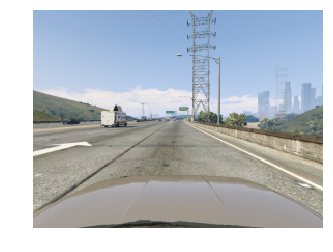

6597
42352
13655
44736
12589
[ -0.88375919   3.04369609  62.94162949  63.33326181   8.96803045
   3.3356415    1.99995363  11.49999535]
[ -0.4163971   24.08108     83.33333333  83.33333333   8.520578     3.120579
   2.279421    15.        ]


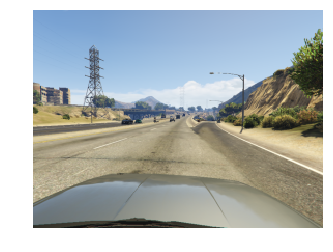

31946
[  0.68686102  63.33333333  15.07584135  63.33333333  11.49999928
   2.26716137   2.86322975  11.49999392]
[ -0.553648    83.33333333   9.652253    83.33333333  15.           2.347198
   3.052802    15.        ]


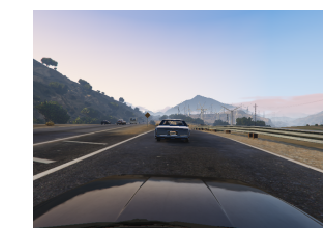

25035
[ -0.12711573   6.85609857  63.33333333  63.33328764   9.04620218
   2.78114861   2.39750242  11.49990988]
[  0.1559601    9.202206    83.33333333  83.33333333   8.161263     2.761264
   2.638736    15.        ]


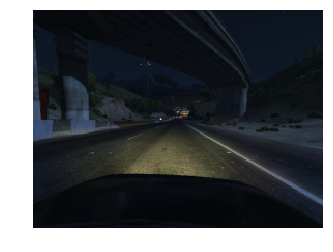

41826
40510
[ -0.09426518   9.44161097  12.9645594   63.33172003   8.7275368
   3.10683459   2.25874281  11.49720657]
[ -0.4431992    7.333463    12.05691     83.33333333   7.853555     2.453555
   2.946445    15.        ]


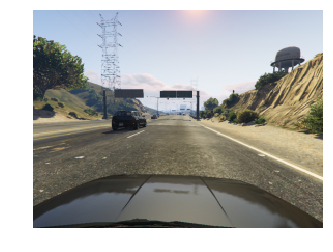

21868
[ -0.70598659  24.11105265  21.96267128  63.33270351   8.2972427
   2.48679602   2.73017538  11.4997797 ]
[ -0.3286591    5.958425    10.28803     83.33333333   8.326213     2.926213
   2.473788    15.        ]


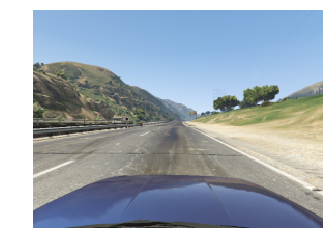

23364
[ -0.35989642  12.33386278  17.7036641   63.32782189   8.02306712
   2.27407789   3.02123654  11.49626243]
[ -0.9242249   12.04668     11.74941     83.33333333   7.724695     2.324695
   3.075305    15.        ]


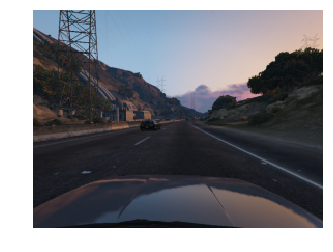

39843
34663
27195
[  1.35983241  63.33333333  63.33332141  63.32849542  11.48406053
   3.2210713    2.28072941   9.16128898]
[  0.5118275   83.33333333  83.33333333  83.33333333  15.           2.425212
   2.974788     7.825212  ]


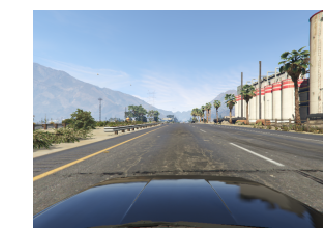

34295
[  0.83147598  63.33332141   2.42255608  63.33315452  11.49932551
   2.55064619   2.60423547  10.0359652 ]
[  2.234253    83.33333333  11.53069     83.33333333  15.           2.844416
   2.555584     8.244416  ]


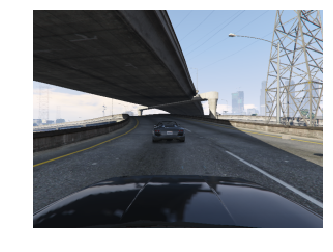

6501
[ -6.59438322  63.33327174   8.9507091   63.32520723  11.49993992
   3.40654159   2.0953598   11.44302702]
[-24.8096      83.33333333   2.844183    83.33333333  15.           3.967953
   1.432047    15.        ]


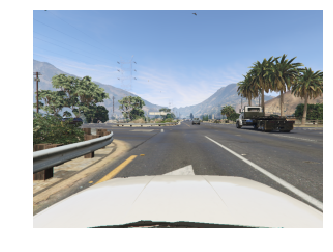

45
[  0.09942305  63.32587878  63.27714602  63.33332936   7.97353172
   2.09820402   3.01582921  11.49999678]
[ -0.2870007   83.33333333  83.33333333  83.33333333   7.426256     2.026256
   3.373744    15.        ]


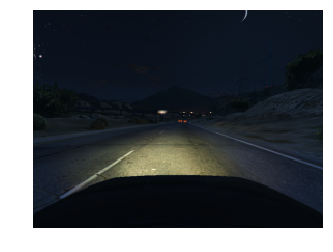

24849
15833
[ -4.39094108e-02   5.02981226e+00   5.69300799e+01   6.33333333e+01
   7.79606622e+00   1.79195690e+00   3.27077192e+00   1.15000000e+01]
[  1.488686     9.836663    83.33333333  83.33333333   7.400644     2.000643
   3.399357    15.        ]


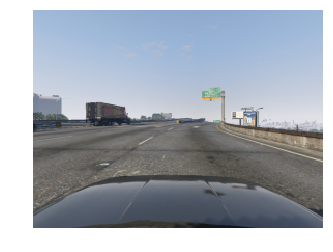

12480
[  0.76484568  56.90106233  63.08088183  63.33333135  10.73013413
   1.87177658   3.28284651  11.49999821]
[ -1.911339    83.33333333  83.33333333  83.33333333  15.           3.308308
   2.091692    15.        ]


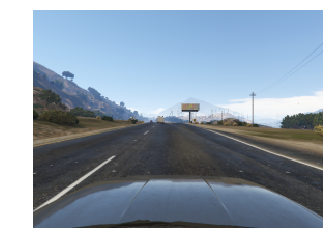

43695
44845
4945
43578
19434
13425
[ -1.34170589  63.33331744   9.28242286  63.33332936  11.49996638
   2.5215444    2.60063648  11.49986124]
[  0.5739632   83.33333333   9.692359    83.33333333  15.           2.279468
   3.120533    15.        ]


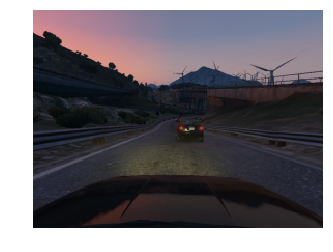

7023
[ -0.47363176   5.48748652  13.12536478  63.3332936    7.50744498
   2.05884171   3.3204754   11.49987555]
[ -0.2081604    7.736257    10.98796     83.33333333   7.52809      2.12809
   3.27191     15.        ]


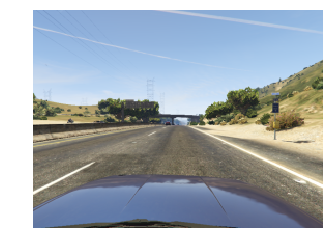

31635
10886
38398
[  0.71334299  63.18044345  17.71037261  51.95366224  11.46698952
   3.13682508   2.24283123   9.41814089]
[ -0.12854     83.33333333  33.77985     83.33333333  15.           3.121768
   2.278232     8.521769  ]


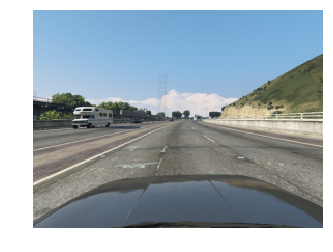

19103
3174
28547
[ -0.27480265  10.22979498  62.77489146  63.33317439   8.86398005
   2.43849444   2.86228722  11.47241795]
[  1.846359     5.33736     83.33333333  83.33333333   7.395472     1.995472
   3.404528    15.        ]


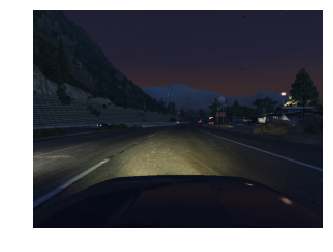

28780
36779
[ -2.25991593e-02   3.51239396e+01   6.32916935e+01   6.33333214e+01
   8.20466536e+00   2.12114763e+00   3.10253859e+00   1.14999900e+01]
[ -0.4984436   49.21716     83.33333333  83.33333333   7.585161     2.185161
   3.214839    15.        ]


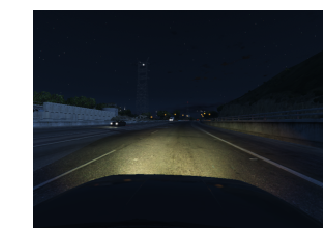

29723
[  0.19847647  57.26369301  56.52501861  63.33331943   8.0305925
   2.26630378   3.06268775  11.49999821]
[ -0.2415009   83.33333333  83.33333333  83.33333333   7.578178     2.178179
   3.221822    15.        ]


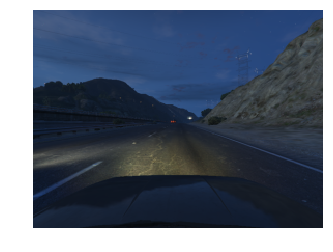

14795
33463
27543
[  1.00807181  57.03934709  63.33333135  63.33333333  11.41793835
   2.56474942   2.46079326  11.49996853]
[ -0.1450806   83.33333333  83.33333333  83.33333333  15.           3.173568
   2.226433    15.        ]


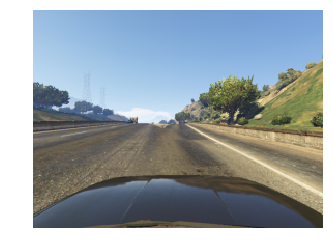

3589
[  2.57648826  63.33333135   5.4444917   63.33333333  11.49999428
   2.06420469   2.93843389  11.49999642]
[ -1.122559    83.33333333  14.00783     83.33333333  15.           2.18206
   3.217941    15.        ]


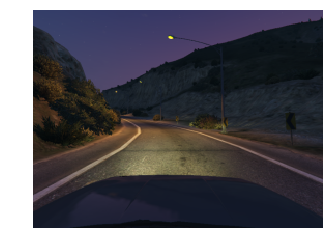

7915
38880
[  0.08556868  63.33266775  20.81362486   9.06038761  11.49984694
   2.93548667   2.42723775   8.26223058]
[  0.3881607   83.33333333  12.79478     11.0152      15.           2.744098
   2.655902     8.144098  ]


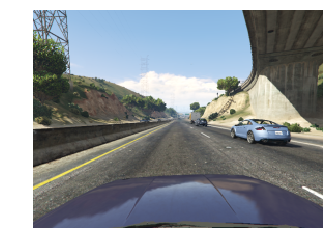

22352
18441
34737
[ -1.44479771  63.33331347   2.50722249  63.33319624  11.48497891
   2.09671736   3.14105028  11.49999034]
[ -1.020966    83.33333333   8.85481     83.33333333  15.           3.090998
   2.309002    15.        ]


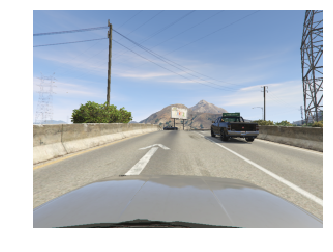

41271
[  0.18415468  25.6441159   16.33312782  63.33087166   8.02815473
   2.23241639   3.1420815   11.49809027]
[  0.7470703   21.94046      6.143466    83.33333333   7.828309     2.428309
   2.971691    15.        ]


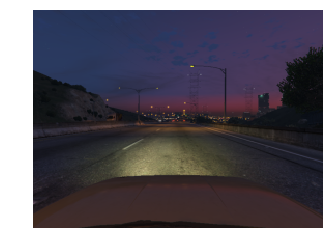

145
13593
1559
[ -0.20091271   5.8236746   16.88888252  63.33333333   8.00840437
   2.191998     3.07411754  11.49999964]
[  0.1986694    1.49003      8.786943    83.33333333   7.581182     2.181183
   3.218817    15.        ]


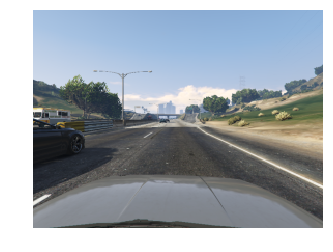

14912
15992
24242
36284
[  1.23491076   3.04167747  59.30759986  63.16573699   9.13085198
   2.92770845   2.43727672  11.15210176]
[ -0.8679504    8.889927    83.33333333  83.33333333   8.893632     3.493631
   1.906369    15.        ]


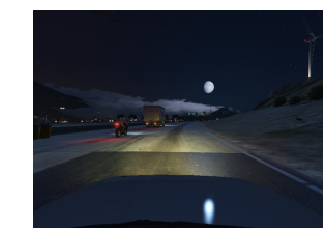

In [106]:
for i in range(100):
    index = random.choice(range(len(filenames)))
    print index
    filepath = '/D/GTA_data/valid/data/' + filenames[index]
    
    y_pred = predict(model, filepath)
    y_true = annot[index]
    error = 0
    for j in range(1, 4):
        dist_pred = y_pred[j] if y_pred[j] < 0.99 else 1
        dist_true = y_true[j] if y_true[j] < 0.99 else 1
        error += (dist_pred - dist_true) ** 2
    
    if error < .5:
        print invert_scale(predict(model, filepath))
        print invert_scale(annot[index])

        im = misc.imread(filepath)
        plt.imshow(im)
        plt.axis('off')
        plt.imsave(str(index) + '.png', im)
        plt.show()

13461
[ -5.88439405e-02   6.33333194e+01   7.43727366e+00   6.33333035e+01
   1.14730706e+01   2.93542159e+00   2.29504061e+00   1.14999986e+01]
[ -0.6792297   83.33333333   8.758311    83.33333333  15.           3.291665
   2.108335    15.        ]


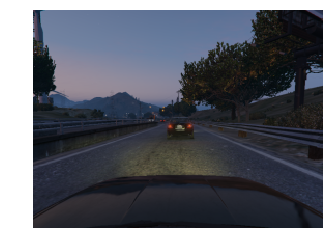

33353
[  3.97026966e-02   6.33294531e+01   6.33246410e+01   6.33288908e+01
   1.14966816e+01   2.67824924e+00   2.68092161e+00   8.50069845e+00]
[ -2.568111    83.33333333  83.33333333  83.33333333  15.           2.322368
   3.077632     7.722368  ]


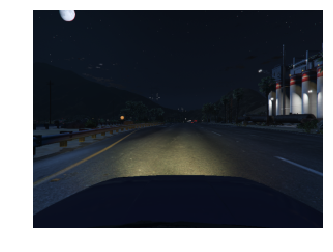

25552
[ -0.07832178  63.33172599   3.9836971   63.33107034  11.49957693
   2.76627344   2.46048427  11.47125673]
[  0.6947632   83.33333333   6.085834    83.33333333  15.           3.196298
   2.203702    15.        ]


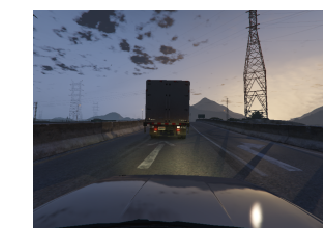

34681
[ -0.07104732  63.33332936  15.3545626   63.33296577  11.49803054
   2.06659937   3.31120604  11.49317074]
[ -2.630096    83.33333333  10.00857     83.33333333  15.           2.442088
   2.957912    15.        ]


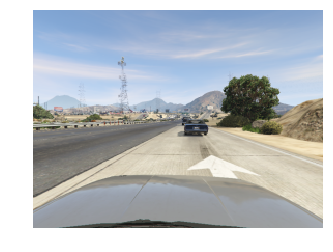

28210
[  1.16891402  63.32993587  16.55034602  63.33333333  11.49933767
   2.97455591   2.2628659   11.49993849]
[  0.4418945   83.33333333  10.34873     83.33333333  15.           2.701888
   2.698112    15.        ]


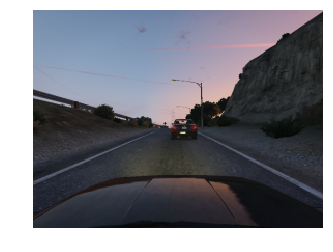

28903
[ -1.57592843  63.33298167   2.33541409  63.18644961  11.49933517
   2.52908981   2.72560757  11.46364498]
[  1.471313    83.33333333   6.362149    83.33333333  15.           2.390609
   3.009391    15.        ]


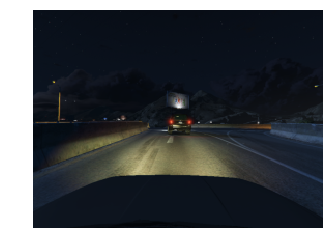

2692
[ -5.13381247e-02   5.91309714e+01   6.33333135e+01   6.33333333e+01
   9.06424880e+00   3.11411822e+00   2.08205104e+00   1.15000000e+01]
[ -1.08623500e-02   8.33333333e+01   8.33333333e+01   8.33333333e+01
   8.96668300e+00   3.56668400e+00   1.83331700e+00   1.50000000e+01]


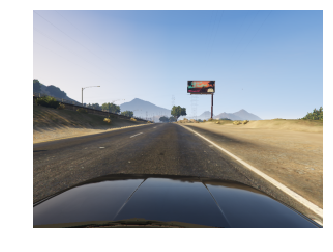

In [108]:
for index in sample_index:
    
    print index
    filepath = '/D/GTA_data/valid/data/' + filenames[index]
    
    y_pred = predict(model, filepath)
    y_true = annot[index]
    error = 0
    for j in range(1, 4):
        dist_pred = y_pred[j] if y_pred[j] < 0.99 else 1
        dist_true = y_true[j] if y_true[j] < 0.99 else 1
        error += (dist_pred - dist_true) ** 2
    
    if error < .5:
        print invert_scale(predict(model, filepath))
        print invert_scale(annot[index])

        im = misc.imread(filepath)
        plt.imshow(im)
        plt.axis('off')
        plt.imsave(str(index) + '.png', im)
        plt.show()

In [107]:
sample_index = [13461, 33353, 25552, 34681, 28210, 28903, 2692]
# 17186
# 20780

[ 0.00825752  0.9787057   0.99999934  0.999686    0.37292209 -0.57529259
 -0.38212365  0.99870676]
[-0.00514715  1.6         1.6         1.6         0.34102333 -0.55897667
 -0.37435667  1.58333333]


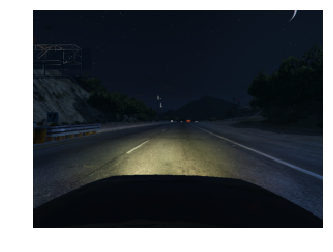

[ 0.00571297  0.82048714  1.          0.99939328  0.39423507 -0.57841146
 -0.38703525  0.99809188]
[ 0.00575746  1.6         1.6         1.6         0.34280533 -0.55719467
 -0.3761385   1.58333333]


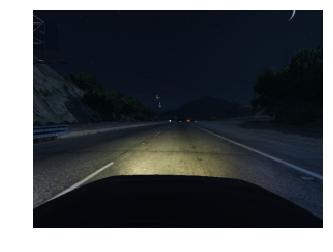

In [59]:
for index in range(2):
    filepath = '/D/GTA_data/valid/data/' + filenames[index]

    print predict(model, filepath)
    print annot[index]

    im = misc.imread(filepath)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

In [66]:
error = np.zeros(8, )

for index in range(len(filenames)):

    filepath = '/D/GTA_data/valid/data/' + filenames[index]
    
    y_pred = predict(model, filepath)
    y_true = annot[index]
    
    for j in range(8):
        
        if j == 0:
            error[j] += (y_pred[j] - y_true[j]) ** 2
        else:
            dist_pred = y_pred[j] if y_pred[j] < 0.99 else 1
            dist_true = y_true[j] if y_true[j] < 0.99 else 1
            error[j] += (dist_pred - dist_true) ** 2

In [69]:
print 'Epoch 21'
print error / len(filenames)

Epoch 21
[ 0.00702674  0.30913593  0.48928984  0.10879352  0.03682381  0.02522302
  0.016326    0.0150109 ]


In [71]:
np.sum(error) / len(filenames)

1.0076297710950581

In [72]:
error = np.zeros(8, )

for index in range(len(filenames)):

    filepath = '/D/GTA_data/valid/data/' + filenames[index]
    
    y_pred = predict(model, filepath)
    y_true = annot[index]
    
    for j in range(8):
        
        if j == 0:
            error[j] += (y_pred[j] - y_true[j]) ** 2
        else:
            dist_pred = y_pred[j]
            dist_true = y_true[j]
            error[j] += (dist_pred - dist_true) ** 2

In [73]:
print error

[   317.76337367  28539.85116038  37415.19197002  21591.30604666
  10008.69376903   1632.86159445    738.20914172  13278.17169753]


In [75]:
print error / len(filenames)

[ 0.00702674  0.63110546  0.82736703  0.47745137  0.22132355  0.03610768
  0.01632412  0.29362195]


In [77]:
np.sum(error) / len(filenames) / 8

0.31379098877056572

In [78]:
model.load_weights('epoch16.hdf5')

error16 = np.zeros(8, )

for index in range(len(filenames)):

    filepath = '/D/GTA_data/valid/data/' + filenames[index]
    
    y_pred = predict(model, filepath)
    y_true = annot[index]
    
    for j in range(8):
        
        if j == 0:
            error16[j] += (y_pred[j] - y_true[j]) ** 2
        else:
            dist_pred = y_pred[j] if y_pred[j] < 0.99 else 1
            dist_true = y_true[j] if y_true[j] < 0.99 else 1
            error16[j] += (dist_pred - dist_true) ** 2

print error16 / len(filenames)

[ 0.00957505  0.32284189  0.49156403  0.10910644  0.03841457  0.02403589
  0.01464624  0.01864045]


In [79]:
model.load_weights('epoch11.hdf5')

error11 = np.zeros(8, )

for index in range(len(filenames)):

    filepath = '/D/GTA_data/valid/data/' + filenames[index]
    
    y_pred = predict(model, filepath)
    y_true = annot[index]
    
    for j in range(8):
        
        if j == 0:
            error11[j] += (y_pred[j] - y_true[j]) ** 2
        else:
            dist_pred = y_pred[j] if y_pred[j] < 0.99 else 1
            dist_true = y_true[j] if y_true[j] < 0.99 else 1
            error11[j] += (dist_pred - dist_true) ** 2

print error11 / len(filenames)

[ 0.01018282  0.32345497  0.51829203  0.11578237  0.04305931  0.02320705
  0.00972663  0.02000977]


In [109]:
model.load_weights('epoch6.hdf5')

error6 = np.zeros(8, )

for index in range(len(filenames)):

    filepath = '/D/GTA_data/valid/data/' + filenames[index]
    
    y_pred = predict(model, filepath)
    y_true = annot[index]
    
    for j in range(8):
        
        if j == 0:
            error6[j] += (y_pred[j] - y_true[j]) ** 2
        else:
            dist_pred = y_pred[j] if y_pred[j] < 0.99 else 1
            dist_true = y_true[j] if y_true[j] < 0.99 else 1
            error6[j] += (dist_pred - dist_true) ** 2

print error6 / len(filenames)

[ 0.00821347  0.44166831  0.61890212  0.13888642  0.11471994  0.03052365
  0.01218489  0.06481662]


In [110]:
model.load_weights('epoch21.hdf5')

error21 = np.zeros(8, )

for index in range(len(filenames)):

    filepath = '/D/GTA_data/valid/data/' + filenames[index]
    
    y_pred = predict(model, filepath)
    y_true = annot[index]
    
    for j in range(8):
        
        if j == 0:
            error21[j] += (y_pred[j] - y_true[j]) ** 2
        else:
            dist_pred = y_pred[j] if y_pred[j] < 0.99 else 1
            dist_true = y_true[j] if y_true[j] < 0.99 else 1
            error21[j] += (dist_pred - dist_true) ** 2

print error21 / len(filenames)

[ 0.00702674  0.30913593  0.48928984  0.10879352  0.03682381  0.02522302
  0.016326    0.0150109 ]


In [81]:
model.load_weights('epoch9.hdf5')

error9 = np.zeros(8, )

for index in range(len(filenames)):

    filepath = '/D/GTA_data/valid/data/' + filenames[index]
    
    y_pred = predict(model, filepath)
    y_true = annot[index]
    
    for j in range(8):
        
        if j == 0:
            error9[j] += (y_pred[j] - y_true[j]) ** 2
        else:
            dist_pred = y_pred[j] if y_pred[j] < 0.99 else 1
            dist_true = y_true[j] if y_true[j] < 0.99 else 1
            error9[j] += (dist_pred - dist_true) ** 2

print error9 / len(filenames)

[ 0.00928255  0.31126746  0.53289277  0.11797282  0.0367572   0.02245253
  0.00905698  0.02606219]


In [82]:
model.load_weights('epoch13.hdf5')

error13 = np.zeros(8, )

for index in range(len(filenames)):

    filepath = '/D/GTA_data/valid/data/' + filenames[index]
    
    y_pred = predict(model, filepath)
    y_true = annot[index]
    
    for j in range(8):
        
        if j == 0:
            error13[j] += (y_pred[j] - y_true[j]) ** 2
        else:
            dist_pred = y_pred[j] if y_pred[j] < 0.99 else 1
            dist_true = y_true[j] if y_true[j] < 0.99 else 1
            error13[j] += (dist_pred - dist_true) ** 2

print error13 / len(filenames)

[ 0.01182182  0.32335841  0.48910719  0.11182012  0.04243422  0.02353798
  0.00968087  0.01873669]


In [83]:
def invert_scale(y):
    y_invert = np.zeros((8, ))
    y_invert[0] = y[0] * angle_max
    y_invert[1] = (y[1] * car_dist_max + car_dist_lim) / 2
    y_invert[2] = (y[2] * car_dist_max + car_dist_lim) / 2
    y_invert[3] = (y[3] * car_dist_max + car_dist_lim) / 2
    y_invert[4] = (y[4] * lane_dist_max + lane_dist_lim) / 2
    y_invert[5] = (y[5] * lane_dist_max + lane_dist_lim) / 2
    y_invert[6] = (y[6] * lane_dist_max + lane_dist_lim) / 2
    y_invert[7] = (y[7] * lane_dist_max + lane_dist_lim) / 2
    return y_invert

### Clean-up data

In [48]:
IMAGES_RAW = '/D/GTA_data/valid/raw/'
IMAGES_CLEAN = '/D/GTA_data/valid/data/'

ANNOT_RAW = '/D/GTA_data/valid/annotation_raw.txt'
ANNOT_CLEAN = '/D/GTA_data/valid/temp.txt'
ANNOT_SCALE = '/D/GTA_data/valid/annotation_scale.txt'

NUM_LABELS = 8
UP_LIM = 100000
angle_lim = 30
car_dist_lim = 60

In [49]:
import os
from shutil import copyfile

# Rename files to zero-leading
filenames = [f for f in listdir(IMAGES_RAW)]
for fn in filenames:
    track_nb = fn.split('_')[0].zfill(5)
    frame_nb = fn.split('_')[1].split('.')[0].zfill(4)
    os.rename(IMAGES_RAW + fn, IMAGES_RAW + track_nb + '_' + frame_nb + '.bmp')
    
# Read annotation to list
with open(ANNOT_RAW) as ant:
    annotation = ant.readlines()
    annotation = [x.strip() for x in annotation] 

annot = np.zeros((len(annotation), NUM_LABELS))
for i in range(len(annotation)):
    annot[i] = annotation[i].split(',')[2:]   

del_id = []
frames_with_car = np.zeros((3, ), dtype=np.int32)

# Iterate through data to find indices of bad data
for i in range(len(annotation)):
    for j in range(NUM_LABELS):
        
        # Clean up too large angle
        if j == 0:
            if annot[i, j] < 0:
                if annot[i, j] < -angle_lim and annot[i, j] > -360 + angle_lim:
                    del_id.append(i)
                    break
            else:
                if annot[i, j] > angle_lim and annot[i, j] < 360 - angle_lim:
                    del_id.append(i)
                    break
        
        # Clean up bad car dist
        if j >= 1 and j <= 3:
            if annot[i, j] < UP_LIM:
                frames_with_car[j - 1] += 1
                if annot[i, j] > car_dist_lim:
                    del_id.append(i)
                    break
            else:
                if (frames_with_car[j - 1] > 0) and (frames_with_car[j - 1] <= 5):
                    for k in range(frames_with_car[j - 1]):
                        del_id.append(i - k - 1)
                frames_with_car[j - 1] = 0
        
        # Clean up lane distance
        if j >= 4 and j <= 7:
            if (annot[i, j] > lane_dist_lim and annot[i, j] < UP_LIM) or (annot[i, j] < 0):
                del_id.append(i)
                break

del_id = list(set(del_id))
print 'Number of bad data: ', len(del_id)
print 'Number of clean data: ', (len(annotation) - len(del_id))

# Remove bad data
mask = np.ones(len(annotation), dtype=bool)
mask[del_id] = False
filenames = [f for f in listdir(IMAGES_RAW)]
filenames.sort()
cleaned_annotation = np.array(annotation)[mask]
cleaned_filenames = np.array(filenames)[mask]

# Copy cleaned data to new directory
for fn in cleaned_filenames:
    copyfile(IMAGES_RAW + fn, IMAGES_CLEAN + fn)
# Write cleaned annotation to new file
f = open(ANNOT_CLEAN, 'a')
for ant in cleaned_annotation:
    f.write(ant + '\n') 
f.close()

Number of bad data:  18871
Number of clean data:  97893


### Rescale data

Rescale all labels to range [-1, 1] ([-0.9, 0.9] in practice to leave a slight margin)

In [50]:
# Read annotation to list
with open(ANNOT_CLEAN) as ant:
    annotation = ant.readlines()
    annotation = [x.strip() for x in annotation] 

annot = np.zeros((len(annotation), NUM_LABELS))
for i in range(len(annotation)):
    annot[i] = annotation[i].split(',')[2:] 
    
max_annot = np.zeros((NUM_LABELS, ))
for i in range(len(annotation)):
    for j in range(NUM_LABELS):
        if annot[i, j] <= UP_LIM and annot[i, j] > max_annot[j]:
            max_annot[j] = annot[i, j]

min_annot = np.min(annot, axis=0)

print 'Max: ', max_annot
print 'Min: ', min_annot

Max:  [ 358.7949     59.99747    59.89577    59.98631    10.79913     5.399129
   10.58974    10.69023 ]
Min:  [-359.9988      1.000407    1.001513    1.001386    0.          0.          0.
    0.      ]


In [51]:
f = open(ANNOT_SCALE, 'a')

for i in range(len(annotation)):
    
    out = annotation[i].split(',')[0].zfill(5)
    out += ', ' + annotation[i].split(',')[1].strip().zfill(4)
    
    if annot[i, 0] > 360 - angle_lim:
        angle = annot[i, 0] - 360
    elif annot[i, 0] < -360 + angle_lim:
        angle = annot[i, 0] + 360 
    else:
        angle = annot[i, 0]
    out += ', ' + `angle / angle_max`
    
    # Rescale car dist from [0, 60] to [-0.9, 0.9]
    for j in range(1, 4):
        if annot[i, j] > UP_LIM:
            dist = car_dist_inac
        else:
            dist = annot[i, j]
        out += ', ' + `(2 * dist - car_dist_lim) / car_dist_max`
    
    # Rescale lane dist from [0, ~11] to [-0.9, 0.9]
    for j in range(4, 8):
        if annot[i, j] > UP_LIM:
            dist = lane_dist_inac
        else:
            dist = annot[i, j]
        out += ', ' + `(2 * dist - lane_dist_lim) / lane_dist_max`
    
    f.write(out + '\n')
    
f.close()

In [52]:
# Read annotation to list
with open(ANNOT_SCALE) as ant:
    annotation = ant.readlines()
    annotation = [x.strip() for x in annotation] 

annot = np.zeros((len(annotation), NUM_LABELS))
for i in range(len(annotation)):
    annot[i] = annotation[i].split(',')[2:] 
    
max_annot = np.zeros((NUM_LABELS, ))
for i in range(len(annotation)):
    for j in range(NUM_LABELS):
        if annot[i, j] <= UP_LIM and annot[i, j] > max_annot[j]:
            max_annot[j] = annot[i, j]

min_annot = np.min(annot, axis=0)

print 'Max: ', max_annot
print 'Min: ', min_annot

Max:  [ 0.8926179   1.6         1.6         1.6         1.58333333  1.58333333
  0.84829     1.58333333]
Min:  [-0.896715   -0.86998779 -0.86995461 -0.86995842 -0.91666667 -0.91666667
 -0.91666667 -0.91666667]


### Code to append training data

In [157]:
# Append training data
f = open('/D/GTA_data/train/annotation_scale.txt', 'a')

for i in range(55092):
    
    out = str(int(annotation[i].split(',')[0]) + 7810).zfill(5)
    out += ',' + ','.join(i for i in annotation[i].split(',')[1:])
    f.write(out + '\n')
    
f.close()

In [158]:
filenames = [f for f in listdir('/D/GTA_data/valid/data/')]
filenames.sort()
for fn in filenames:
    track_nb = fn.split('_')[0]
    frame_nb = fn.split('_')[1].split('.')[0]
    os.remove('/D/GTA_data/valid/data/'+ fn, '/D/GTA_data/train/data/' + track_nb + '_' + frame_nb + '.bmp')

In [ ]:
filenames = [f for f in listdir('/D/GTA_data/valid/data/')]
filenames.sort()
for fn in filenames:
    track_nb = fn.split('_')[0]
    frame_nb = fn.split('_')[1].split('.')[0]
    os.rename('/D/GTA_data/valid/data/'+ fn, '/D/GTA_data/train/data/' + track_nb + '_' + frame_nb + '.bmp')

In [54]:
filenames = [f for f in listdir('/D/GTA_data/valid/data/')]
filenames.sort()
for fn in filenames:
    track_nb = int(fn.split('_')[0])
    if track_nb < 1395:
        os.remove('/D/GTA_data/valid/data/'+ fn)

In [53]:
with open('/D/GTA_data/valid/annotation_scale.txt') as ant:
    annotation = ant.readlines()
    annotation = [x.strip() for x in annotation]
f = open('/D/GTA_data/valid/annotation_scale2.txt', 'a')
for a in annotation:
    if int(a.split(',')[0]) >= 1395:
        f.write(a + '\n')
f.close()